In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

#Data Scraping and formatting


In [18]:
print("\n[STEP 1] Downloading data from Yahoo Finance...")

START_DATE = '2000-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

# S&P 500
print("  Downloading S&P 500...")
spx_ticker = yf.Ticker('^GSPC')
spx_data = spx_ticker.history(start=START_DATE, end=END_DATE)
spx_monthly = spx_data['Close'].resample('M').last()
spx_monthly.index = spx_monthly.index.tz_localize(None)
spx_monthly.name = 'sp500'

print(f"  ✓ S&P 500: {len(spx_monthly)} months")

# FX pairs
print("  Downloading FX pairs...")
fx_tickers = {
    'AUDUSD=X': 'exalus', 'BRLUSD=X': 'exbzus', 'CADUSD=X': 'excaus',
    'CNYUSD=X': 'exchus', 'DKKUSD=X': 'exdnus', 'HKDUSD=X': 'exhkus',
    'INRUSD=X': 'exinus', 'JPYUSD=X': 'exjpus', 'KRWUSD=X': 'exkous',
    'MXNUSD=X': 'exmxus', 'MYRUSD=X': 'exmaus', 'NZDUSD=X': 'exnzus',
    'NOKUSD=X': 'exnous', 'SGDUSD=X': 'exsius', 'ZARUSD=X': 'exsfus',
    'SEKUSD=X': 'exsdus', 'CHFUSD=X': 'exszus',
    'TWDUSD=X': 'extaus', 'THBUSD=X': 'exthus', 'GBPUSD=X': 'exukus',
    'EURUSD=X': 'exeuus',
}

fx_data = {}
for ticker, col_name in fx_tickers.items():
    try:
        fx_ticker = yf.Ticker(ticker)
        data = fx_ticker.history(start=START_DATE, end=END_DATE)

        if len(data) > 0 and 'Close' in data.columns:
            monthly = data['Close'].resample('M').last()
            monthly.index = monthly.index.tz_localize(None)
            if ticker.startswith(('AUD', 'EUR', 'GBP', 'NZD')):
                fx_data[col_name] = 1 / monthly
            else:
                fx_data[col_name] = monthly

            print(f"    ✓ {col_name}")
    except Exception as e:
        print(f"    ✗ {col_name}: {str(e)[:40]}")

fx_monthly = pd.DataFrame(fx_data)
print(f"  ✓ Downloaded {len(fx_data)} currency pairs")

# Combine and clean
print("\n  Aligning data...")
combined = fx_monthly.join(spx_monthly, how='inner')
print(f"  Combined: {combined.shape}")
combined = combined.dropna()
print(f"  After dropna: {combined.shape}")
print(f"  Date range: {combined.index.min().date()} to {combined.index.max().date()}")

if len(combined) == 0:
    raise ValueError("No data after alignment - check data sources")

# Separate
fx_prices = combined.drop('sp500', axis=1)
spx_prices = combined[['sp500']]

# Calculate returns
fx_returns = fx_prices.pct_change().iloc[1:]
spx_returns = spx_prices.pct_change().iloc[1:]

# Clean infinite values
fx_returns = fx_returns.replace([np.inf, -np.inf], np.nan).dropna()
spx_returns = spx_returns.replace([np.inf, -np.inf], np.nan)

# Ensure alignment
common_idx = fx_returns.index.intersection(spx_returns.index)
fx_returns = fx_returns.loc[common_idx]
spx_returns = spx_returns.loc[common_idx]

print(f"  ✓ Final dataset: {len(fx_returns)} months")
print(f"  Date range: {fx_returns.index.min().date()} to {fx_returns.index.max().date()}")


[STEP 1] Downloading data from Yahoo Finance...
  ✓ S&P 500: 313 months
    ✓ exalus
    ✓ exbzus
    ✓ excaus
    ✓ exchus
    ✓ exdnus
    ✓ exhkus
    ✓ exinus
    ✓ exjpus
    ✓ exkous
    ✓ exmxus
    ✓ exmaus
    ✓ exnzus
    ✓ exnous
    ✓ exsius
    ✓ exsfus
    ✓ exsdus
    ✓ exszus
    ✓ extaus
    ✓ exthus
    ✓ exukus
    ✓ exeuus
  ✓ Downloaded 21 currency pairs

  Aligning data...
  Combined: (313, 22)
  After dropna: (237, 22)
  Date range: 2006-05-31 to 2026-01-31
  ✓ Final dataset: 236 months
  Date range: 2006-06-30 to 2026-01-31


#Exploratory Data Analysis


[STEP 2] EXPLORATORY DATA ANALYSIS

Basic Statistics
--------------------------------------------------------------------------------

S&P 500 Returns:
  Mean:       0.821% per month
  Median:     1.470%
  Std Dev:    4.385%
  Skewness:  -0.628
  Kurtosis:   1.206
  Min:       -16.94%
  Max:        12.68%

FX Returns Summary:
  Mean volatility:  4.868%
  Min volatility:   0.197% (exhkus)
  Max volatility:   47.309% (extaus)

Correlation Analysis
--------------------------------------------------------------------------------

Highly correlated FX pairs (|r| > 0.7): 23

Top 10 correlated pairs:
  exdnus <-> exeuus: -0.9979
  exalus <-> exnzus: +0.8632
  exdnus <-> exsdus: +0.8390
  exsdus <-> exeuus: -0.8360
  exnous <-> exsdus: +0.8326
  exmaus <-> exsius: +0.8244
  exalus <-> exsius: -0.8188
  exkous <-> exsius: +0.7745
  exnzus <-> exsius: -0.7735
  exdnus <-> exszus: +0.7699

Top 5 FX correlations with S&P 500:
  excaus: +0.5881
  exnous: +0.5875
  exmxus: +0.5701
  exsfus: +0.5441

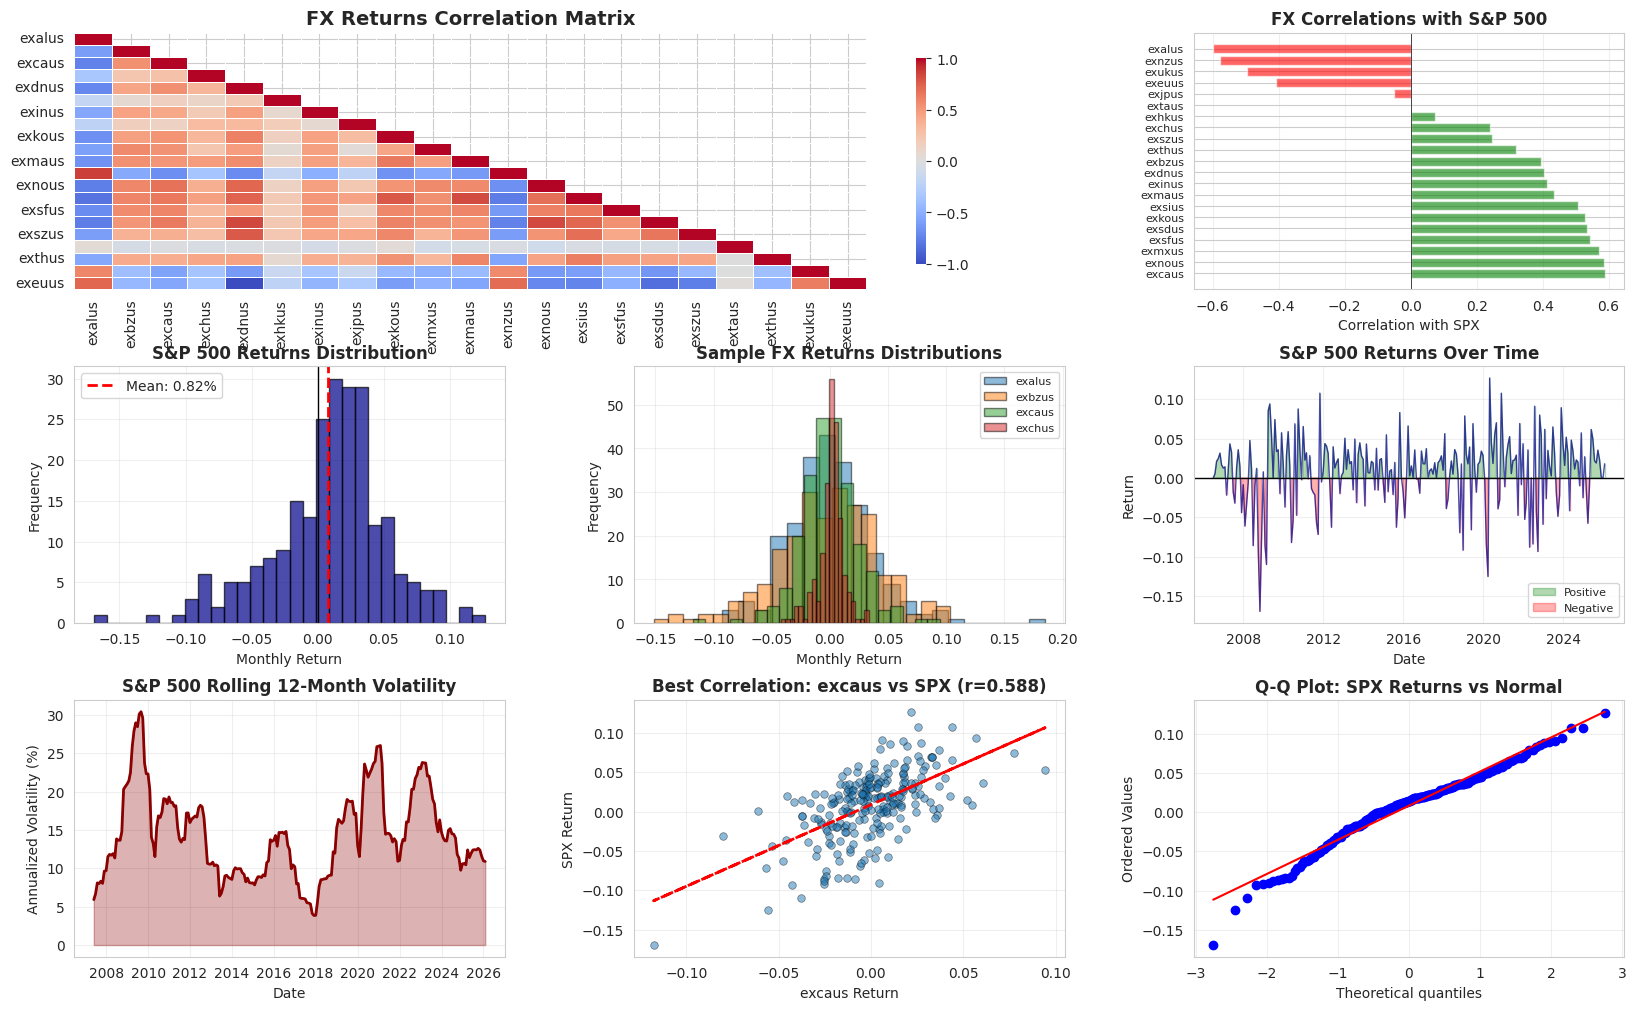

In [19]:

print("\n" + "="*80)
print("[STEP 2] EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic Statistics
print("\nBasic Statistics")
print("-" * 80)

spx_ret = spx_returns['sp500']

print("\nS&P 500 Returns:")
print(f"  Mean:     {spx_ret.mean()*100:>7.3f}% per month")
print(f"  Median:   {spx_ret.median()*100:>7.3f}%")
print(f"  Std Dev:  {spx_ret.std()*100:>7.3f}%")
print(f"  Skewness: {spx_ret.skew():>7.3f}")
print(f"  Kurtosis: {spx_ret.kurtosis():>7.3f}")
print(f"  Min:      {spx_ret.min()*100:>7.2f}%")
print(f"  Max:      {spx_ret.max()*100:>7.2f}%")

print("\nFX Returns Summary:")
print(f"  Mean volatility:  {fx_returns.std().mean()*100:.3f}%")
print(f"  Min volatility:   {fx_returns.std().min()*100:.3f}% ({fx_returns.std().idxmin()})")
print(f"  Max volatility:   {fx_returns.std().max()*100:.3f}% ({fx_returns.std().idxmax()})")

# Correlation Analysis
print("\nCorrelation Analysis")
print("-" * 80)

correlation_matrix = fx_returns.corr()

# High correlations
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

print(f"\nHighly correlated FX pairs (|r| > 0.7): {len(high_corr_pairs)}")
if high_corr_pairs:
    print("\nTop 10 correlated pairs:")
    for curr1, curr2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"  {curr1} <-> {curr2}: {corr:>+.4f}")

# Correlations with SPX
spx_corr = fx_returns.corrwith(spx_ret).sort_values(ascending=False)

print(f"\nTop 5 FX correlations with S&P 500:")
for curr, corr in spx_corr.head(5).items():
    print(f"  {curr}: {corr:>+.4f}")

print(f"\nBottom 5 FX correlations with S&P 500:")
for curr, corr in spx_corr.tail(5).items():
    print(f"  {curr}: {corr:>+.4f}")

print(f"\nInterpretation:")
print(f"  • High FX inter-correlations ({len(high_corr_pairs)} pairs) suggest")
print(f"    that PCA will be effective at reducing dimensionality")
print(f"  • FX-SPX correlations range from {spx_corr.min():+.3f} to {spx_corr.max():+.3f}")

# Create EDA Visualizations
print("\nCreating EDA Visualizations...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: FX Correlation Heatmap
ax = fig.add_subplot(gs[0, :2])
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=False, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax, vmin=-1, vmax=1, annot=False)
ax.set_title('FX Returns Correlation Matrix', fontsize=14, fontweight='bold')

# Plot 2: FX-SPX Correlations
ax = fig.add_subplot(gs[0, 2])
colors = ['green' if x > 0 else 'red' for x in spx_corr.values]
ax.barh(range(len(spx_corr)), spx_corr.values, color=colors, alpha=0.6)
ax.set_yticks(range(len(spx_corr)))
ax.set_yticklabels(spx_corr.index, fontsize=8)
ax.set_xlabel('Correlation with SPX', fontsize=10)
ax.set_title('FX Correlations with S&P 500', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# Plot 3: SPX Returns Distribution
ax = fig.add_subplot(gs[1, 0])
ax.hist(spx_ret, bins=30, edgecolor='black', alpha=0.7, color='darkblue')
ax.axvline(spx_ret.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {spx_ret.mean()*100:.2f}%')
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Monthly Return')
ax.set_ylabel('Frequency')
ax.set_title('S&P 500 Returns Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: FX Returns Distribution
ax = fig.add_subplot(gs[1, 1])
sample_cols = min(4, len(fx_returns.columns))
for col in fx_returns.columns[:sample_cols]:
    ax.hist(fx_returns[col], bins=20, alpha=0.5, label=col, edgecolor='black')
ax.set_xlabel('Monthly Return')
ax.set_ylabel('Frequency')
ax.set_title('Sample FX Returns Distributions', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 5: Returns over time
ax = fig.add_subplot(gs[1, 2])
ax.plot(spx_ret.index, spx_ret, linewidth=1, alpha=0.7, color='darkblue')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.fill_between(spx_ret.index, 0, spx_ret,
                where=(spx_ret>0), alpha=0.3, color='green', label='Positive')
ax.fill_between(spx_ret.index, 0, spx_ret,
                where=(spx_ret<0), alpha=0.3, color='red', label='Negative')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title('S&P 500 Returns Over Time', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Rolling volatility
ax = fig.add_subplot(gs[2, 0])
rolling_vol = spx_ret.rolling(window=12).std() * np.sqrt(12) * 100
ax.plot(rolling_vol.index, rolling_vol, linewidth=2, color='darkred')
ax.fill_between(rolling_vol.index, rolling_vol, alpha=0.3, color='darkred')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility (%)')
ax.set_title('S&P 500 Rolling 12-Month Volatility', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 7: Scatter plot
ax = fig.add_subplot(gs[2, 1])
best_fx = spx_corr.index[0]
ax.scatter(fx_returns[best_fx], spx_ret, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
z = np.polyfit(fx_returns[best_fx], spx_ret, 1)
p = np.poly1d(z)
ax.plot(fx_returns[best_fx], p(fx_returns[best_fx]), "r--", linewidth=2)
ax.set_xlabel(f'{best_fx} Return')
ax.set_ylabel('SPX Return')
ax.set_title(f'Best Correlation: {best_fx} vs SPX (r={spx_corr[best_fx]:.3f})',
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 8: QQ Plot
ax = fig.add_subplot(gs[2, 2])
from scipy import stats
stats.probplot(spx_ret, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: SPX Returns vs Normal', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: eda_analysis.png")

#Modeling

In [20]:
X = fx_returns
y = spx_ret

# Train/test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"  Train: {len(X_train)} | Test: {len(X_test)}")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# CV setup
tscv = TimeSeriesSplit(n_splits=5)
max_components = min(15, X_train.shape[1])


  Train: 188 | Test: 48


#PCR

In [21]:
pca_full = PCA()
pca_full.fit(X_train_scaled)

cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"  Components for 95% variance: {n_95}")

cv_scores = []
for n in range(1, max_components):
    pca_temp = PCA(n_components=n)
    X_pca = pca_temp.fit_transform(X_train_scaled)
    scores = cross_val_score(LinearRegression(), X_pca, y_train, cv=tscv, scoring='r2')
    cv_scores.append(scores.mean())

optimal_n_pca = np.argmax(cv_scores) + 1
print(f"  Optimal components: {optimal_n_pca} (CV R² = {max(cv_scores):.4f})")

pca = PCA(n_components=optimal_n_pca)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pcr = LinearRegression().fit(X_train_pca, y_train)
y_pred_pcr = pcr.predict(X_test_pca)

r2_pcr = r2_score(y_test, y_pred_pcr)
dir_acc_pcr = np.mean(np.sign(y_test) == np.sign(y_pred_pcr))
print(f"  R²: {r2_pcr:.4f} | Dir Acc: {dir_acc_pcr:.2%}")

# Which PCs are most important for prediction
print(f"\nTop {optimal_n_pca} Principal Components (by prediction importance):")
pc_coefficients = pcr.coef_
pc_importance = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(optimal_n_pca)],
    'Coefficient': pc_coefficients,
    'Abs_Coefficient': np.abs(pc_coefficients),
    'Variance_Explained': pca.explained_variance_ratio_[:optimal_n_pca]
})
pc_importance = pc_importance.sort_values('Abs_Coefficient', ascending=False)

for idx, row in pc_importance.iterrows():
    print(f"  {row['PC']}: coef={row['Coefficient']:>+.4f}, explains {row['Variance_Explained']*100:.1f}% variance")

# Show top currency loadings for most important PCs
print(f"\nTop 3 currency loadings for most predictive PCs:")
loadings_df = pd.DataFrame(
    pca.components_,
    columns=X_train.columns,
    index=[f"PC{i+1}" for i in range(optimal_n_pca)]
)

for i in range(min(3, optimal_n_pca)):
    pc_name = pc_importance.iloc[i]['PC']
    print(f"\n  {pc_name} (coef: {pc_importance.iloc[i]['Coefficient']:+.4f}):")
    top_loadings = loadings_df.loc[pc_name].abs().nlargest(3)
    for currency in top_loadings.index:
        loading = loadings_df.loc[pc_name, currency]
        print(f"    {currency}: {loading:>+.4f}")

  Components for 95% variance: 15
  Optimal components: 3 (CV R² = 0.3813)
  R²: 0.2975 | Dir Acc: 77.08%

Top 3 Principal Components (by prediction importance):
  PC2: coef=-0.0127, explains 7.0% variance
  PC1: coef=-0.0085, explains 50.0% variance
  PC3: coef=-0.0063, explains 5.9% variance

Top 3 currency loadings for most predictive PCs:

  PC2 (coef: -0.0127):
    exjpus: +0.5457
    exszus: +0.3896
    exmxus: -0.3024

  PC1 (coef: -0.0085):
    exalus: +0.2812
    exsius: -0.2803
    exsdus: -0.2686

  PC3 (coef: -0.0063):
    exjpus: +0.4475
    exukus: +0.3684
    exthus: +0.3381


#PLS

In [22]:
print("\n[STEP 5] Partial Least Squares...")

cv_scores_pls = []
for n in range(1, max_components):
    pls_temp = PLSRegression(n_components=n)
    scores = cross_val_score(pls_temp, X_train_scaled, y_train, cv=tscv, scoring='r2')
    cv_scores_pls.append(scores.mean())

optimal_n_pls = np.argmax(cv_scores_pls) + 1
print(f"  Optimal components: {optimal_n_pls}")

pls = PLSRegression(n_components=optimal_n_pls)
pls.fit(X_train_scaled, y_train)
y_pred_pls = pls.predict(X_test_scaled).ravel()

r2_pls = r2_score(y_test, y_pred_pls)
dir_acc_pls = np.mean(np.sign(y_test) == np.sign(y_pred_pls))
print(f"  R²: {r2_pls:.4f} | Dir Acc: {dir_acc_pls:.2%}")



[STEP 5] Partial Least Squares...
  Optimal components: 2
  R²: 0.2891 | Dir Acc: 77.08%


#Lasso

In [23]:
print("\n[STEP 6] Lasso Regression...")

lasso = LassoCV(cv=tscv, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

r2_lasso = r2_score(y_test, y_pred_lasso)
dir_acc_lasso = np.mean(np.sign(y_test) == np.sign(y_pred_lasso))
n_selected = (lasso.coef_ != 0).sum()

print(f"  Best alpha: {lasso.alpha_:.6f}")
print(f"  Features selected: {n_selected}")
print(f"  R²: {r2_lasso:.4f} | Dir Acc: {dir_acc_lasso:.2%}")

if n_selected > 0:
    coefs = pd.Series(lasso.coef_, index=X_train.columns)
    selected = coefs[coefs != 0].sort_values(key=abs, ascending=False)
    print(f"\n  Selected features:")
    for feat, coef in selected.items():
        print(f"    {feat}: {coef:>+.6f}")


[STEP 6] Lasso Regression...
  Best alpha: 0.001650
  Features selected: 12
  R²: 0.2963 | Dir Acc: 72.92%

  Selected features:
    exmxus: +0.009646
    exjpus: -0.008699
    exkous: +0.008199
    excaus: +0.008111
    exnous: +0.007240
    exnzus: -0.004180
    exszus: -0.002221
    exsfus: +0.002166
    exbzus: -0.000742
    exsdus: +0.000221
    exinus: +0.000215
    exhkus: +0.000003


#Results


RESULTS

Model       R²  Dir_Acc
  PCR 0.297516 0.770833
  PLS 0.289070 0.770833
Lasso 0.296257 0.729167

Best model: PCR

✓ Saved: model_results.png


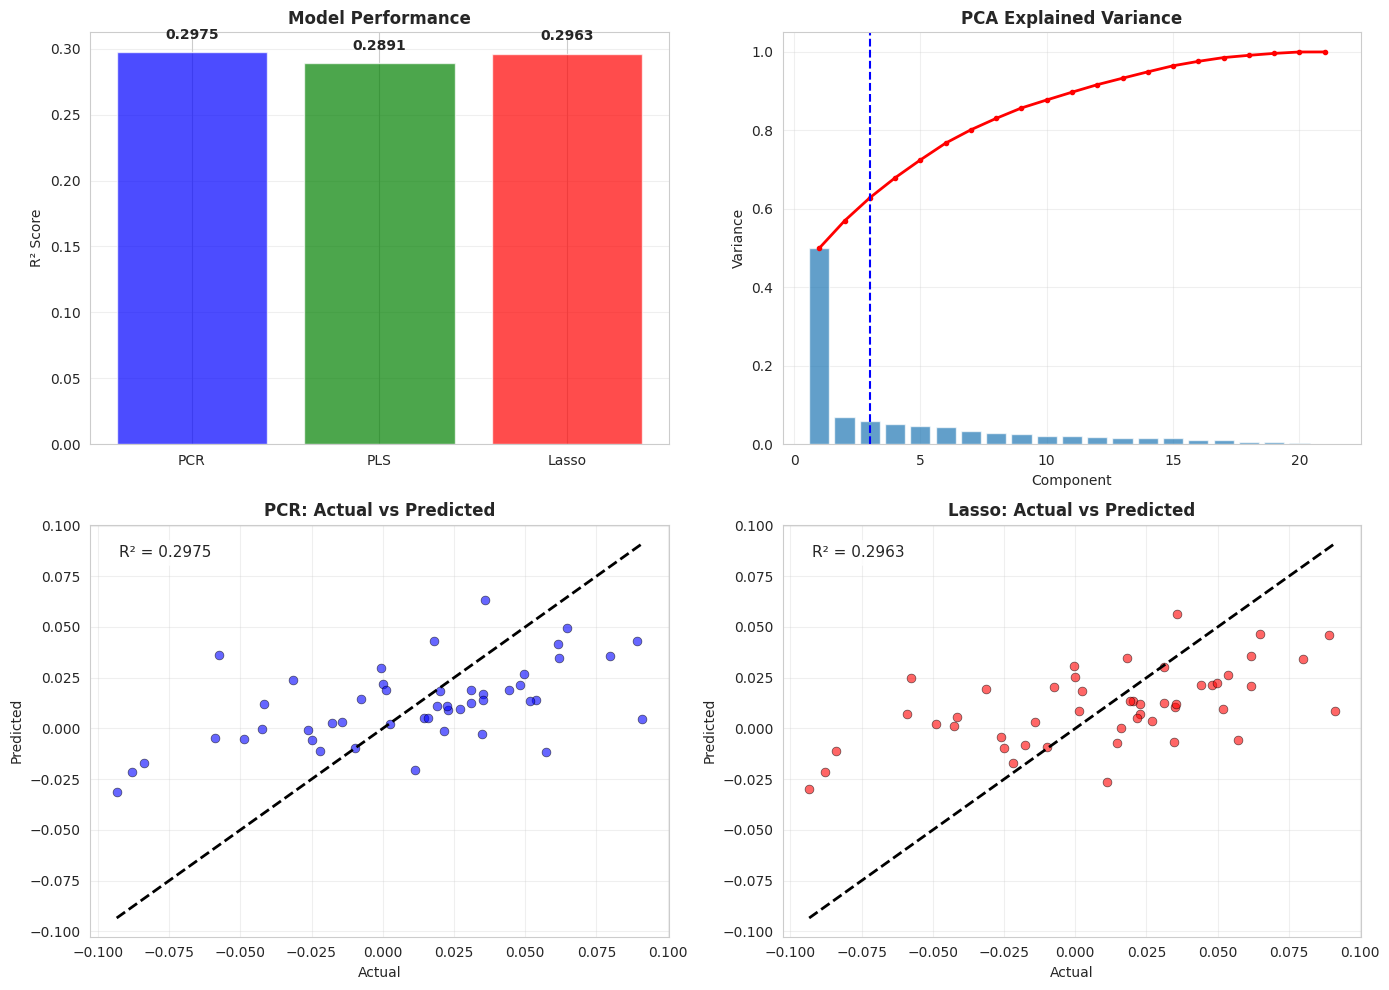


ANALYSIS COMPLETE!

Dataset: 236 months from 2006-06-30 to 2026-01-31
High FX correlations: 23 pairs
Best model: PCR (R² = 0.2975)


In [24]:
print("\n" + "="*80)
print("RESULTS")
print("="*80)

results = pd.DataFrame({
    'Model': ['PCR', 'PLS', 'Lasso'],
    'R²': [r2_pcr, r2_pls, r2_lasso],
    'Dir_Acc': [dir_acc_pcr, dir_acc_pls, dir_acc_lasso]
})

print("\n" + results.to_string(index=False))
print(f"\nBest model: {results.loc[results['R²'].idxmax(), 'Model']}")

# Create results visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Model comparison
ax = axes[0, 0]
colors = ['blue', 'green', 'red']
ax.bar(results['Model'], results['R²'], color=colors, alpha=0.7)
ax.set_ylabel('R² Score')
ax.set_title('Model Performance', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (m, r2) in enumerate(zip(results['Model'], results['R²'])):
    ax.text(i, r2 + 0.01, f'{r2:.4f}', ha='center', fontweight='bold')

# Plot 2: PCA variance
ax = axes[0, 1]
ax.bar(range(1, len(pca_full.explained_variance_ratio_)+1),
       pca_full.explained_variance_ratio_, alpha=0.7)
ax.plot(range(1, len(cumsum_var)+1), cumsum_var, 'r-o', linewidth=2, markersize=3)
ax.axvline(x=optimal_n_pca, color='b', linestyle='--')
ax.set_xlabel('Component')
ax.set_ylabel('Variance')
ax.set_title('PCA Explained Variance', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plots 3-4: Actual vs Predicted
for idx, (name, pred, color) in enumerate([('PCR', y_pred_pcr, 'blue'),
                                             ('Lasso', y_pred_lasso, 'red')]):
    ax = axes[1, idx]
    ax.scatter(y_test, pred, alpha=0.6, s=40, color=color, edgecolors='black', linewidth=0.5)
    min_val, max_val = min(y_test.min(), pred.min()), max(y_test.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{name}: Actual vs Predicted', fontweight='bold')
    ax.grid(True, alpha=0.3)
    r2_val = r2_score(y_test, pred)
    ax.text(0.05, 0.95, f'R² = {r2_val:.4f}', transform=ax.transAxes,
            fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('model_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: model_results.png")

plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nDataset: {len(X)} months from {X.index.min().date()} to {X.index.max().date()}")
print(f"High FX correlations: {len(high_corr_pairs)} pairs")
print(f"Best model: {results.loc[results['R²'].idxmax(), 'Model']} (R² = {results['R²'].max():.4f})")
print("="*80)